In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# load and prepare data

df_11_SSP1 = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/linear_SSP1_11_2040.csv')
df_11_SSP1_test = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/linear_SSP1_11_2050.csv')
df_11_SSP1_cubic = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/cubic_SSP1_11_2040.csv')
df_11_SSP1_cubicroot = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/cubicroot_SSP1_11_2040.csv')

df_11_SSP1_cubic.tail()

,USD,0,2,4,6,8,10,12,14,16,18,20,reduction
196,3920,0.0,3.92,31.36,105.84,250.88,490.0,846.72,1344.56,2007.04,2857.68,3920.0,58.7773
197,3940,0.0,3.94,31.52,106.38,252.16,492.5,851.04,1351.42,2017.28,2872.26,3940.0,58.7783
198,3960,0.0,3.96,31.68,106.92,253.44,495.0,855.36,1358.28,2027.52,2886.84,3960.0,58.7793
199,3980,0.0,3.98,31.84,107.46,254.72,497.5,859.68,1365.14,2037.76,2901.42,3980.0,58.7803
200,4000,0.0,4.00,32.00,108.00,256.00,500.0,864.00,1372.00,2048.00,2916.00,4000.0,58.7813


In [130]:
"""
This class will create a model which finds the reduction that comes with a certain 
carbon price path. 
"""

class model:
    
    def __init__(self):
        
        self.lin_path = []
        self.lin_reduction = []
        
        self.train_path = []
        self.train_reduction = []
        
    def train(self, lin_path, lin_reduction, train_path, train_reduction):
        """
        Here the weights for each ctax step is calculated

        Load values: linear paths and random paths including the reductions from TIMER
        output is b values (weigths) for given ctax levels 
        """
        # check input
        
        # linear
        self.lin_path.append(lin_path)
        self.lin_path = np.asarray(self.lin_path)       
        self.lin_reduction.append(lin_reduction)
        self.lin_reduction = np.asarray(self.lin_reduction)
        
        # training
        self.train_path.append(train_path)
        self.train_path = np.asarray(self.train_path)     
        self.train_reduction.append(train_reduction)
        self.train_reduction = np.asarray(self.train_reduction)
        
        # make dataframes
        self.df_combined_lin = pd.concat([lin_path.reset_index(drop=True),
                                 lin_reduction.reset_index(drop=True)], axis=1)        
        
        self.df_combined_train = pd.concat([train_path.reset_index(drop=True),
                                 train_reduction.reset_index(drop=True)], axis=1)
        
        df_tot = pd.DataFrame()
        
        # find reduction levels for linear and training path at same ctax level @ all ctax levels        
        for index in range(0, len(lin_path) - 10, 10):
                    
            # ctax and reduction of random path @ random index
            ctax_val_train = self.train_path[0][index+10][-1]
            cur_red_train = self.train_reduction[0][index+10]
    
            # get the linear reduction corresponding to the ctax level of training input
            last_column = self.df_combined_lin.columns[-2]        
            cur_red_lin = self.df_combined_lin.loc[self.df_combined_lin[last_column] == ctax_val_train]         
            cur_red_lin = cur_red_lin['reduction'].values[0]
            
            # use sets of 200 dollar differences to calculate weights 
            cur_ctax = [i for i in range(index*20, index*20 + 220, 20)]
            
            print(cur_ctax)
                                
            # create dataframe with cur_ctax as labels and list for linear reduction
            cur_train_paths = pd.DataFrame()
            cur_lin_paths = pd.DataFrame()
            cur_lin_reds = []

            for ctax in cur_ctax:

                cur_ctax_path = self.df_combined_train.loc[self.df_combined_train[last_column] == ctax]
                cur_train_paths = cur_train_paths.append(cur_ctax_path) 
                cur_lin_reds.append(self.df_combined_lin.loc[self.df_combined_lin[last_column] == ctax]['reduction'].values[0])              
                cur_ctax_path_lin = self.df_combined_lin.loc[self.df_combined_lin[last_column] == ctax]               
                cur_lin_paths = cur_lin_paths.append(cur_ctax_path_lin)
                
            # calculate delta_C for all training paths
            cur_lin_path =  self.lin_path[0][index]                       
            lin_paths_no_red = cur_lin_paths.drop('reduction', axis=1)            
            train_paths_no_red = cur_train_paths.drop('reduction', axis=1)
            
            # empty df for all delta_c
            delta_c = pd.DataFrame()   
            
            print(train_paths_no_red)
            
            # calculate normalised delta C for every train path with corresponding lin path CHECK DIT
            for i in range(len(lin_paths_no_red)):
                
                delta_c = delta_c.append((lin_paths_no_red.loc[i+index] - train_paths_no_red.loc[i+index]) / 
                                        lin_paths_no_red.loc[i+index][-1])
                   
            # set columns in right order FOR SOME REASON THEY GET SWITCHED?
            cols = delta_c.columns.tolist()
            cols = list(map(int, cols))
            cols.sort()
            cols = [str(e) for e in cols]
            delta_c = delta_c[cols]                  
                
            # random reduction values for the paths
            cur_train_reds = cur_train_paths['reduction'].values
            
            # take only the two averages of normalised delta_c WHY? nog hard coded
            delta_c_avg = []

            for delta_c in delta_c.values:
                delta_c1 = sum(delta_c[0:4])/5
                delta_c2 = sum(delta_c[5:])/6
                delta_c_avg.append([delta_c1, delta_c2])

#             print('\n',cur_train_reds - cur_lin_reds)
            
            # define objective function HAAKJE?
            def objective_delta_c_avg(x, delta_c_avg, cur_lin_reds, cur_train_reds):
                """
                Objective function that is used to find the weights 
                """
                calc_diff = sum(abs(cur_train_reds[i] - (cur_lin_reds[i] + x.dot(delta_c_avg[i]))) 
                                for i in range(len(cur_train_reds))) 

                return calc_diff
        
            # set initial values to 0
            x0 = [i*0 for i in delta_c_avg[0]]

            
            # minimize objective functions   
            res = minimize(objective_delta_c_avg, x0, args=(delta_c_avg, cur_lin_reds, cur_train_reds),
                          method='Nelder-Mead')

            # print results
#             print(res)
    
            # save weights to ctax level
            weights = pd.DataFrame([[res.x[0], res.x[1], 200 + (index*20)]], 
                                   columns=['b1','b2','ctax'])
            
            df_tot = pd.concat([df_tot, weights])            
            df_tot = df_tot.reset_index(drop=True)
          
           
        # make df and add to self
        self.weights = df_tot
        
        print(df_tot)
        
        # quick vis of paths found
        plt.plot(df_tot['ctax'], df_tot['b1'], color='blue', linewidth=3)
        plt.plot(df_tot['ctax'], df_tot['b2'], color='red', linewidth=3)
        plt.xlabel('final ctax')
        plt.ylabel('weight')
        plt.legend(['b1','b2'])
        
        fig, axs = plt.subplots(2, 1)
        axs[0].plot(df_tot['ctax'], df_tot['b1'], color='blue')
        axs[1].plot(df_tot['ctax'], df_tot['b2'], color='red')
        
    def run(self, test_path):
        """
        here we use the calculated weights to determine the reduction for a
        random chosen ctax path
        
        input: ctax path [list]
        
        output: reduction [integer]  
        """
        
        # find corresponding ctax and weights for test path
        cur_ctax = test_path[-1]        
        last_column = self.df_combined_lin.columns[-2]       
        cur_lin_path = self.df_combined_lin.loc[self.df_combined_lin[last_column] == cur_ctax]                
        lin_path_no_red = cur_lin_path.drop('reduction', axis=1).values[0]                
        cur_lin_red = cur_lin_path['reduction'].values[0]
        
        
        # calculate normalised delta C for test path
        delta_c = (lin_path_no_red - test_path) / lin_path_no_red[-1]
        

        # take only the two averages of normalised delta_c NOG HARD CODED
        delta_c_avg = []
        delta_c1 = sum(delta_c[0:4])/5
        delta_c2 = sum(delta_c[5:])/6
        delta_c_avg.append([delta_c1, delta_c2])
        
        
        # multiply delta C with the weights to find reduction      
        df_sort = self.weights.iloc[(self.weights['ctax'] - cur_ctax).abs().argsort()[:1]]
        
        b1 = df_sort['b1'].values[0]
        b2 = df_sort['b2'].values[0]
        
        print(cur_lin_red)
        
        test_red = cur_lin_red - (delta_c1 * b1 + delta_c2 * b2)
        
        real_red = self.df_combined_train.loc[self.df_combined_train[last_column] == cur_ctax]['reduction'].values[0]
        
        print('\n', 'weights: ', b1, b2,
              '\n', 'delta Cs: ', delta_c1, delta_c2,
              '\n', 'reductions (test, real): ',  test_red, real_red)
                

# check if model works
paths_linear = df_11_SSP1.drop(['USD','reduction'], axis = 1)
reduction_linear = df_11_SSP1['reduction']

paths_cubic = df_11_SSP1_cubic.drop(['USD','reduction'], axis = 1)
reduction_cubic = df_11_SSP1_cubic['reduction']

paths_cubicroot = df_11_SSP1_cubicroot.drop(['USD','reduction'], axis = 1)
reduction_cubicroot = df_11_SSP1_cubicroot['reduction']

first_row = list(range(0,11)) 

path_combi = [first_row]
red_combi = [0]

for i in range(1, len(paths_cubic), 2):
    path_combi.append(paths_cubic.loc[i].values)
    path_combi.append(paths_cubicroot.loc[i+1].values)
    red_combi.append(reduction_cubic.loc[i])
    red_combi.append(reduction_cubicroot.loc[i+1])
    
path_combi = pd.DataFrame(path_combi, columns=paths_cubic.columns.values)
print(path_combi)

red_combi = pd.DataFrame(red_combi, columns=['reduction'])


# paths train is 1/2 cubic and 1/2 root

x = model()

# x.train(paths_linear, reduction_linear, paths_cubic, reduction_cubic)
x.train(paths_linear, reduction_linear, path_combi, red_combi)

x.weights

test_path = paths_cubicroot.loc[184].values

x.run(test_path)

# fig, ax = plt.subplots()

# print('random path: ',random_path)

# ax.scatter([x.nearest1, x.nearest2], [x.reduction1, x.reduction2])
# ax.scatter(x.key_val, x.reduction, color = 'red')
# ax.plot([x.nearest1, x.nearest2], [x.reduction1, x.reduction2], '--')

# ax.set_xlabel('price')
# ax.set_ylabel('reduction')

# x.reduction

       0            2            4            6            8           10  \
0    0.0     1.000000     2.000000     3.000000     4.000000     5.000000   
1    0.0     0.020000     0.160000     0.540000     1.280000     2.500000   
2    0.0    18.566355    23.392142    26.777318    29.472252    31.748021   
3    0.0     0.060000     0.480000     1.620000     3.840000     7.500000   
4    0.0    37.132711    46.784284    53.554636    58.944504    63.496042   
..   ...          ...          ...          ...          ...          ...   
196  0.0  1819.502823  2292.429907  2624.177164  2888.280695  3111.306062   
197  0.0     3.940000    31.520000   106.380000   252.160000   492.500000   
198  0.0  1838.069178  2315.822049  2650.954482  2917.752947  3143.054083   
199  0.0     3.980000    31.840000   107.460000   254.720000   497.500000   
200  0.0  1856.635533  2339.214191  2677.731800  2947.225199  3174.802104   

              12           14           16           18      20  
0       6

IndexError: list index out of range

[Text(-2.0, 0, ''),
 Text(0.0, 0, ''),
 Text(2.0, 0, ''),
 Text(4.0, 0, ''),
 Text(6.0, 0, ''),
 Text(8.0, 0, ''),
 Text(10.0, 0, ''),
 Text(12.0, 0, '')]

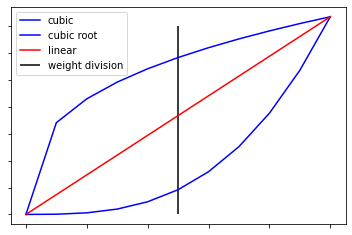

In [27]:
cubic_path = paths_cubic.loc[184].values
cubicroot_path = paths_cubicroot.loc[184].values
lin_path = paths_linear.loc[184].values

fig, axs = plt.subplots(1, 1)
axs.plot(cubic_path, color='blue', label='cubic')
axs.plot(cubicroot_path, color='blue', label='cubic root')
axs.plot(lin_path, color='red', label='linear')
axs.vlines(5,[0], 3500, color='black', label='weight division')
# axs.fill_between(cubicroot_path, lin_path)
axs.legend()

# Turn off tick labels
axs.set_yticklabels([])
axs.set_xticklabels([])

0         0.0
1        20.0
2        40.0
3        60.0
4        80.0
        ...  
196    3920.0
197    3940.0
198    3960.0
199    3980.0
200    4000.0
Name: 20, Length: 201, dtype: float64
[[3820.0], [3840.0], [3860.0], [3880.0], [3900.0], [3920.0], [3940.0], [3960.0], [3980.0], [4000.0]]
Coefficients: 
 [0.01236331]
Mean squared error: 50.03
Coefficient of determination: 0.80


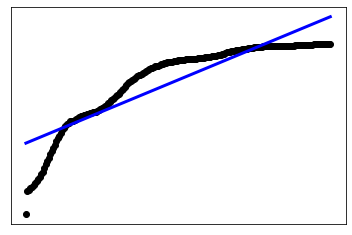

In [64]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

costs = df_11_SSP1['20']
reduction = df_11_SSP1['reduction'].values

print(costs)

# Use only one feature
# costs = costs[:, np.newaxis, 2]

costs_list = []

for cost in costs:
    costs_list.append([cost])
    
costs = costs_list

print(costs[-10:])

# Split the data into training/testing sets, kan niet want pad loopt omhoog
costs_train = costs
costs_test = costs

# Split the targets into training/testing sets
reduction_train = reduction
reduction_test = reduction

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(costs_train, reduction_train)

# Make predictions using the testing set
reduction_pred = regr.predict(costs_test)

# print(reduction_test - reduction_pred)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(reduction_test, reduction_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(reduction_test, reduction_pred))

# Plot outputs
plt.scatter(costs_test, reduction_test,  color='black')
plt.plot(costs_test, reduction_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

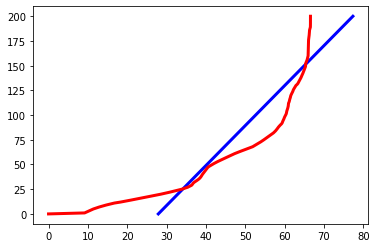

In [102]:
"""
Linear regression using sklearn, here we try to find the linear fit corresponding to the costcurve.
"""

X = df_11_SSP1.drop('reduction', axis=1)
y = df_11_SSP1['reduction']

X_test = df_11_SSP1_test.drop('reduction', axis=1)
y_test = df_11_SSP1_test['reduction']

linear_regression = linear_model.LinearRegression()

linear_regression.fit(X,y)

y_pred = linear_regression.predict(X)

x_axes = df_11_SSP1.index.values

plt.plot(y_pred, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)


0.804469469607436


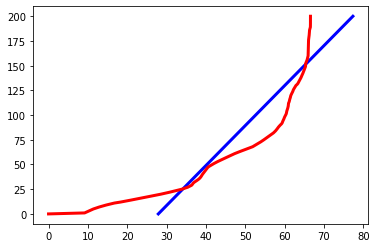

In [89]:
# Ridge regression

"""
Ridge regression addresses some of the problems of Ordinary Least Squares by imposing
a penalty on the size of the coefficients. The ridge coefficients minimize a penalized 
residual sum of squares
"""

ridge_reg = linear_model.Ridge(alpha=.5)

ridge_reg.fit(X,y)

y_pred_ridge = ridge_reg.predict(X)

plt.plot(y_pred_ridge, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = ridge_reg.score(X,y)

print(score)

0.03853142926464648


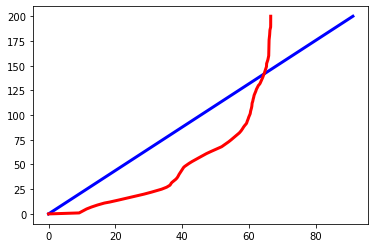

In [101]:
# Kernel ridge

"""
combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick.
It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels,
this corresponds to a non-linear function in the original space.
"""

from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=1.0)
clf.fit(X, y)

y_pred_clf = clf.predict(X_test)

plt.plot(y_pred_clf, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = clf.score(X,y)

print(score)

0.8832715065513569


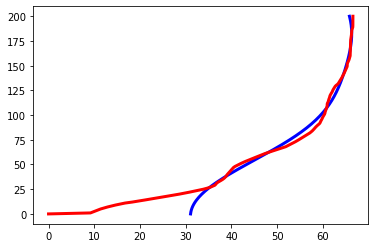

In [108]:
# Support Vector Machine

from sklearn import svm

svm_reg = svm.SVR()

svm_reg.fit(X,y)

y_pred_SVM = svm_reg.predict(X)

plt.plot(y_pred_SVM, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = svm_reg.score(X,y)

print(score)

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


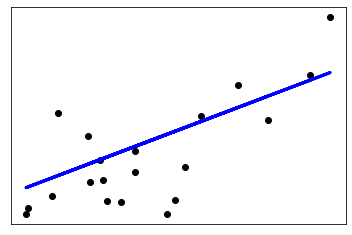

In [14]:
## Voorbeeld

# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

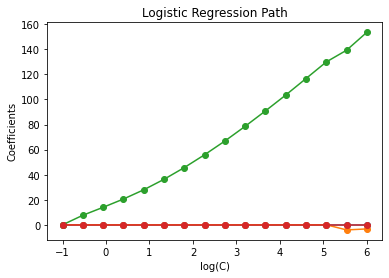

In [26]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

iris = datasets.load_iris()
X = iris.data # dit zou dan de paden van de reductie kunnen zijn
y = iris.target 

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()